# MAHTS testing

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [61]:
%matplotlib inline

import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import measure
from skimage.morphology import disk
from skimage.morphology import square
from skimage.morphology import binary_dilation
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_spatialtools import interpolate_2d
from dea_plotting import display_map
from dea_spatialtools import contour_extract
from dea_plotting import map_shapefile


def largest_region(bool_array, **kwargs):
    
    '''
    Takes a boolean array and identifies the largest contiguous region of 
    connected True values. This is returned as a new array with cells in 
    the largest region marked as True, and all other cells marked as False.
    
    Last modified: August 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    bool_array : boolean array
        A boolean array (numpy or xarray DataArray) with True values for
        the areas that will be inspected to find the largest group of 
        connected cells
    **kwargs : 
        Optional keyword arguments to pass to `measure.label`
        
    Returns
    -------
    largest_region : boolean array
        A boolean array with cells in the largest region marked as True, 
        and all other cells marked as False.       
        
    '''
    
    # First, break boolean array into unique, descrete regions/blobs
    blobs_labels = measure.label(bool_array, background=0, **kwargs)
    
    # Count the size of each blob, excluding the background class (0)
    ids, counts = np.unique(blobs_labels[blobs_labels > 0], 
                            return_counts=True) 
    
    # Identify the region ID of the largest blob
    largest_region_id = ids[np.argmax(counts)]
    
    # Produce a boolean array where 1 == the largest region
    largest_region = blobs_labels == largest_region_id
    
    return largest_region


def mask_ocean(bool_array, **kwargs):
    '''
    Identifies ocean by selecting the largest connected area of water
    pixels, then dilating this region by 1 pixel to include mixed pixels
    '''
    
    try:
        ocean_mask = largest_region(bool_array, **kwargs)
        ocean_mask = binary_dilation(ocean_mask, 
                                     selem=square(3))

        return ocean_mask
    except:
        return None


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')

### Load virtual products catalogue


In [3]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [4]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

In [92]:
# # Gold Coast
# query = {'x': (153.49,  153.68),
#          'y': (-28.08, -28.2681),
#          'time': ('2000', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}


# # Moreton Bay
# query = {'x': (153.00, 153.25),
#          'y': (-26.81, -27.44),
#          'time': ('2008', '2008'),
#          'cloud_cover': [0, 80]}

# # Moreton Bay seam test
# query = {'x': (153.10, 153.18),
#          'y': (-26.70, -26.83),
#          'time': ('2000', '2010'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Moreton Bay small
# query = {'x': (153.16, 153.2840),
#          'y': (-27.315, -27.4416),
#          'time': ('2000', '2010'),
# #          'output_crs': 'EPSG:32756',
# #          'resolution': (-30, 30),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# Fremantle
query = {'x': (115.699173,  115.811948),
         'y': (-31.941483, -32.079094),
         'time': ('2000', '2018'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80]}


# Preview study area
display_map(x=query['x'], y=query['y'])

## Load virtual product

In [8]:
product = catalog['ls_nbart_indices']
ds = product.load(dc, **query)
ds

<xarray.Dataset>
Dimensions:  (time: 477, x: 362, y: 513)
Coordinates:
  * y        (y) float64 -3.535e+06 -3.535e+06 ... -3.55e+06 -3.55e+06
  * x        (x) float64 3.77e+05 3.771e+05 3.771e+05 ... 3.878e+05 3.879e+05
  * time     (time) datetime64[ns] 2003-05-11T01:46:46.497322 ... 2018-12-30T02:11:31.228906
Data variables:
    mndwi    (time, y, x) float32 dask.array<chunksize=(1, 513, 362), meta=np.ndarray>
    ndwi     (time, y, x) float32 dask.array<chunksize=(1, 513, 362), meta=np.ndarray>
    awei_ns  (time, y, x) float32 dask.array<chunksize=(1, 513, 362), meta=np.ndarray>
    awei_sh  (time, y, x) float32 dask.array<chunksize=(1, 513, 362), meta=np.ndarray>
Attributes:
    crs:      PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984"...

In [ ]:
ds.awei_ns.isel(time=slice(0, 8)).plot.imshow(col='time', col_wrap=4, robust=True)

## Model tides

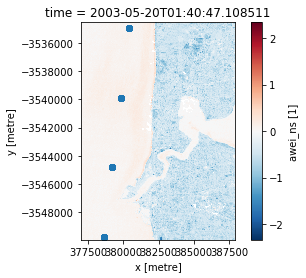

In [9]:
# Pull out subset of modelling points for region around satellite data
bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.1).wkt)
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'i': np.unique(tidepoints_df.time, 
                                                       return_inverse=True)[1], 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Plot a sample timestep
ds.isel(time=1).awei_ns.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [13]:
out = []

for i in range(0, len(ds.time)):

    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_gdf[tidepoints_gdf.i == i].geometry.x,
    y_coords = tidepoints_gdf[tidepoints_gdf.i == i].geometry.y,
    z_coords = tidepoints_gdf[tidepoints_gdf.i == i].tide_m

    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=ds.isel(time=i),
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              fill_nearest=True,
                              sigma=10)

    # Convert to float32 to save memory and add to list
    out.append(out_tide.astype(np.float32))
    
# Create xarray.DataArray and add as a data variable in satellite data
tide_da = (xr.DataArray(data=np.dstack(out), 
                        coords=[ds.y, ds.x, ds.time], 
                        dims=['y', 'x', 'time'],
                        attrs={'units': 'm'})
                
           # Re-order dimensions to match satellite data
           .transpose('time', 'y', 'x'))

# Determine tide cutoff
tide_cutoff = tide_da.median(dim='time')

# Add as measurement in satellite dataset
ds['tide_m'] = tide_da

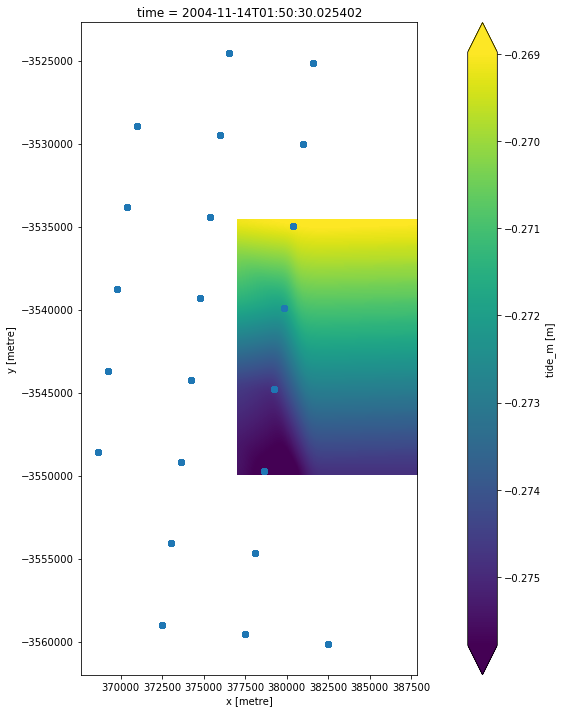

In [14]:
# Plot 
ds['tide_m'].isel(time=58).plot.imshow(robust=True, cmap='viridis', size=12)
tidepoints_gdf.plot(ax=plt.gca())

## Threshold tides

In [ ]:
# tide_cutoff = tide_da.quantile(dim='time', q=[0.20, 0.50, 0.80])
# da_year = ds.sel(time='2005').ndwi.compute()

# low_da = da_year.where(tide_da < tide_cutoff.sel(quantile=0.2)).median(dim='time')
# med_da = da_year.where(tide_da > tide_cutoff.sel(quantile=0.5)).median(dim='time')
# high_da = da_year.where(tide_da > tide_cutoff.sel(quantile=0.8)).median(dim='time')

# fig, axes = plt.subplots(1, 3, figsize=(18, 10))
# low_da.plot.imshow(ax=axes[0], vmin=-0.8, vmax=0.8, 
#                    add_colorbar=False, add_labels=False, cmap='RdBu')
# med_da.plot.imshow(ax=axes[1], vmin=-0.8, vmax=0.8, 
#                    add_colorbar=False, add_labels=False, cmap='RdBu')
# high_da.plot.imshow(ax=axes[2], vmin=-0.8, vmax=0.8, 
#                     add_colorbar=False, add_labels=False, cmap='RdBu')

# # test = ds.where(ds.tide_m < tide_cutoff.sel(quantile=0.2))[['ndwi']].median(dim='time', keep_attrs=True)
# # write_geotiff(filename='continuous_tides_test3.tif', dataset=test)

## Generate yearly composites

In [15]:
yearly_list = []

for year in np.unique(ds.time.dt.year):
    
    print(f'Processing {year}')

    # Pull out a single year and mask to keep above median tide pixels
    year_ds = ds.sel(time=str(year)).compute()
    year_ds = year_ds.where(year_ds.tide_m > tide_cutoff)
    
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    
    # Write each variable to file
    for i in median_ds:
        write_geotiff(filename=f'output_data/{i}_{str(year)}.tif', 
                      dataset=median_ds[[i]])

    # Assign year dimension and append to list
    median_ds = median_ds.assign_coords(year=str(year)).expand_dims('year')    
    yearly_list.append(median_ds)

# Concatenate all annual layers unto a single ds
yearly_ds = xr.concat(yearly_list, dim='year')


Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


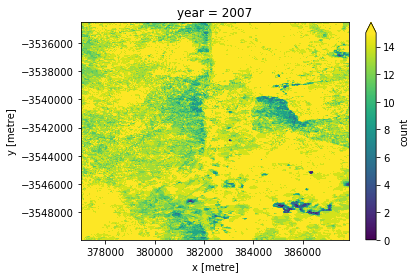

In [86]:
yearly_ds['count'].sel(year='2007').plot(vmin=0, vmax=15)   #.count(dim=['x', 'y'])

## Extract shoreline contours

Operating in single z-value, multiple arrays mode


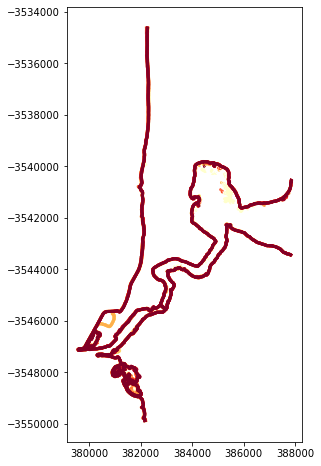

In [69]:
water_index = 'mndwi'
index_threshold = 0.0

# Apply index and threshold
thresholded_ds = yearly_ds[water_index] > index_threshold

# Drop empty timesteps
thresholded_ds = (thresholded_ds
                  .sel(year=thresholded_ds.sum(dim=['x', 'y']) > 0))

# Generate all time 600 m buffer from ocean
full_sea_mask = mask_ocean(thresholded_ds.median(dim='year'))
buffer_ocean = binary_dilation(full_sea_mask, disk(20))
buffer_land = binary_dilation(~full_sea_mask, disk(20))
sea_buffer = buffer_ocean & buffer_land

# Generate sea mask for each timestep
yearly_sea_mask = (thresholded_ds
                   .groupby('year')
                   .apply(mask_ocean))

# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
masked_ds = yearly_ds[water_index].where(yearly_sea_mask & sea_buffer)

# Prepare attributes as input to contour extract
attribute_data = {'year': thresholded_ds.year.values.tolist()}  
attribute_dtypes = {'year': 'str'}

# Extract contours with custom attribute fields:
output_path = f'output_data/contours_{water_index}_{index_threshold:.2f}'
contours_gdf = contour_extract(z_values=[index_threshold],
                               ds_array=masked_ds,
                               ds_crs=f'EPSG:{ds.crs.epsg}',
                               ds_affine=ds.geobox.transform,
                               output_shp=f'{output_path}.shp',
                               attribute_data=attribute_data,
                               attribute_dtypes=attribute_dtypes,
                               min_vertices=2,                                 
                               verbose=False,                                   
                               dim='year')

# Export geojson
contours_gdf.to_crs(epsg=4326).to_file(filename=f'{output_path}.geojson', 
                                       driver='GeoJSON')

# Plot
contours_gdf.plot(column='year', figsize=(12, 8), cmap='YlOrRd', linewidth=3)
# plt.gca().set_xlim(547500, 565500) 
# plt.gca().set_ylim(-3125000, -3109000)

In [ ]:
# map_shapefile(gdf=contours_gdf, hover_col='year')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)